In [12]:
import jax
import jax.numpy as jnp
import diffrax as dfx
from jax import random
import optax
import matplotlib.pyplot as plt
from bioreaction.simulation.simfuncs.basic_de import one_step_de_sim_expanded

In [29]:
# Define the ODE function
def ode_func(t, y, params):
    return params.sum(axis=-1) - y  # (y * params).sum(axis=-1) - y

# Smooth approximation for maximum
def smooth_max(a, b, epsilon=1e-2):
    return epsilon * jnp.log(jnp.exp(a / epsilon) + jnp.exp(b / epsilon))

# Smooth maximum approximation using softplus
def smooth_max2(a, b):
    return jnp.log1p(jnp.exp(a - b)) + b  # Softplus-based approximation


def max_value_ode(t, y, args):
    # args is a tuple (params, max_val)
    params, epsilon = args
    max_val = y[1]
    dy_dt = ode_func(t, y[0], params)
    # max_val = jnp.max(jnp.vstack([max_val, y[0]]), axis=0)
    max_val = smooth_max(max_val, y[0], epsilon)
    # return dy_dt, jnp.sin(y[0])
    return dy_dt, max_val


# Modified function to solve the ODE and track the maximum value with params
def solve_ode_and_track_max(ode_func, y0, t0, t1, params, max_steps=1000, idx_output=-1, epsilon=1e1):

    solver = dfx.Dopri5()
    initial_max = y0  # Initial max is the initial condition
    saveat = dfx.SaveAt(ts=jnp.linspace(t0, t1, max_steps))
    # saveat = dfx.SaveAt(steps=True)    
    
    # Solve the ODE with an auxiliary variable to track the max
    solution = dfx.diffeqsolve(
        dfx.ODETerm(max_value_ode),
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=(y0, initial_max),
        args=(params, epsilon),  # Pass params and initial max as args
        saveat=saveat,
        adjoint=dfx.BacksolveAdjoint()  # This enables differentiation
    )
    
    max_value = solution.ys[1][-1]  # Get the max value reached
    return solution, max_value[idx_output]

# Define a loss function to optimize params
def loss_fn(params, y0, t0, t1, target_max):
    _, max_value = solve_ode_and_track_max(ode_func, y0, t0, t1, params)
    return (max_value - target_max) ** 2  # Squared error loss


@jax.jit
def optimize_step(params, opt_state, y0, t0, t1, target_max):
    loss, grads = jax.value_and_grad(loss_fn)(params, y0, t0, t1, target_max)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Initialize parameters and settings
n_circuits = 1
key = random.PRNGKey(0)
params = random.normal(key, (2, 2))     # Start with random parameters
y0 = jnp.array([1.0] * 2)            # Initial condition
# params = random.normal(key, ())     # Start with random parameters
# y0 = jnp.array([1.0])            # Initial condition
t0, t1 = 0.0, 10.0               # Start and end times
target_max = 5.0                 # Desired maximum value
n_steps = 1000                   # Number of optimization steps

# Set up optax optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

# Optimization loop
for i in range(n_steps):
    params, opt_state, current_loss = optimize_step(params, opt_state, y0, t0, t1, target_max)
    if i % 100 == 0:
        print(f"Step {i}, Loss: {current_loss}, Params: {params}")

print(f"Optimized Params: {params}")

solution_steps, max_value = solve_ode_and_track_max(ode_func, y0, t0, t1, params)


Step 0, Loss: nan, Params: [[nan nan]
 [nan nan]]


KeyboardInterrupt: 

In [42]:
x1 = jnp.ones(10) * 2.
x2 = jnp.linspace(0, 2, 10)
max_val = smooth_max1(x1, x2, epsilon=1e-1)
# max_val = smooth_max(x1, x2)
max_val, x1, x2

(Array([2.       , 2.       , 2.       , 2.0000002, 2.0000017, 2.0000138,
        2.0001273, 2.0011675, 2.010289 , 2.0693147], dtype=float32),
 Array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32),
 Array([0.        , 0.22222222, 0.44444445, 0.6666667 , 0.8888889 ,
        1.1111112 , 1.3333334 , 1.5555556 , 1.7777778 , 2.        ],      dtype=float32))

In [27]:
params = random.normal(key, (2, 2))     # Start with random parameters

loss, grads = jax.value_and_grad(loss_fn)(params, y0, t0, t1, target_max)
grads

Array([[nan, nan],
       [nan, nan]], dtype=float32)

In [3]:
solution_steps, max_value = solve_ode_and_track_max(ode_func, y0, t0, t1, params)


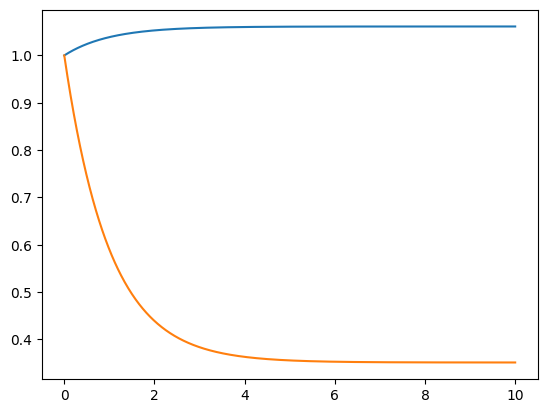

In [4]:
plt.plot(solution_steps.ts, solution_steps.ys[0])